In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
fetch_california_housing().keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [3]:
data = fetch_california_housing()

In [4]:
california_df = pd.DataFrame(data.data, columns=data.feature_names)
california_df["MedHouseVal"] = data.target
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

# EDA

In [6]:
california_df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

<Figure size 1600x1600 with 0 Axes>

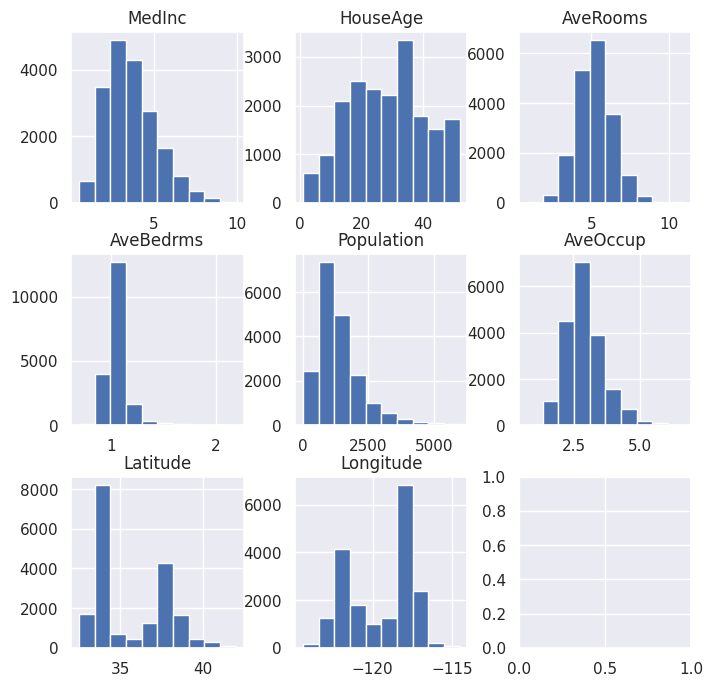

In [7]:
california_df = california_df.query("MedHouseVal<5")
california_df = california_df.query("MedInc<10")
california_df = california_df.query("AveRooms<11")
california_df = california_df.query("AveOccup<6.7")
california_df = california_df.query("Population<6000")
california_df = california_df.query("AveBedrms<2.2 and AveBedrms>0.7")

sns.set_theme()
plt.figure(figsize=(16, 16))
fig, axs = plt.subplots(3, 3, figsize=(8, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
columns = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        ax.hist(california_df[columns[i]], bins=10)
        ax.set_title(columns[i])
plt.show()

In [8]:
# Разбиение выборки
X = california_df[list(california_df)[:-1]]
y = california_df["MedHouseVal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Линейная модель
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
linear_regression.score(X_test, y_test)

0.6290171929456423

In [10]:
# Модель дерева
decision_regressor = DecisionTreeRegressor()
decision_regressor.fit(X_train, y_train)
decision_regressor.score(X_test, y_test)

0.541194402125307

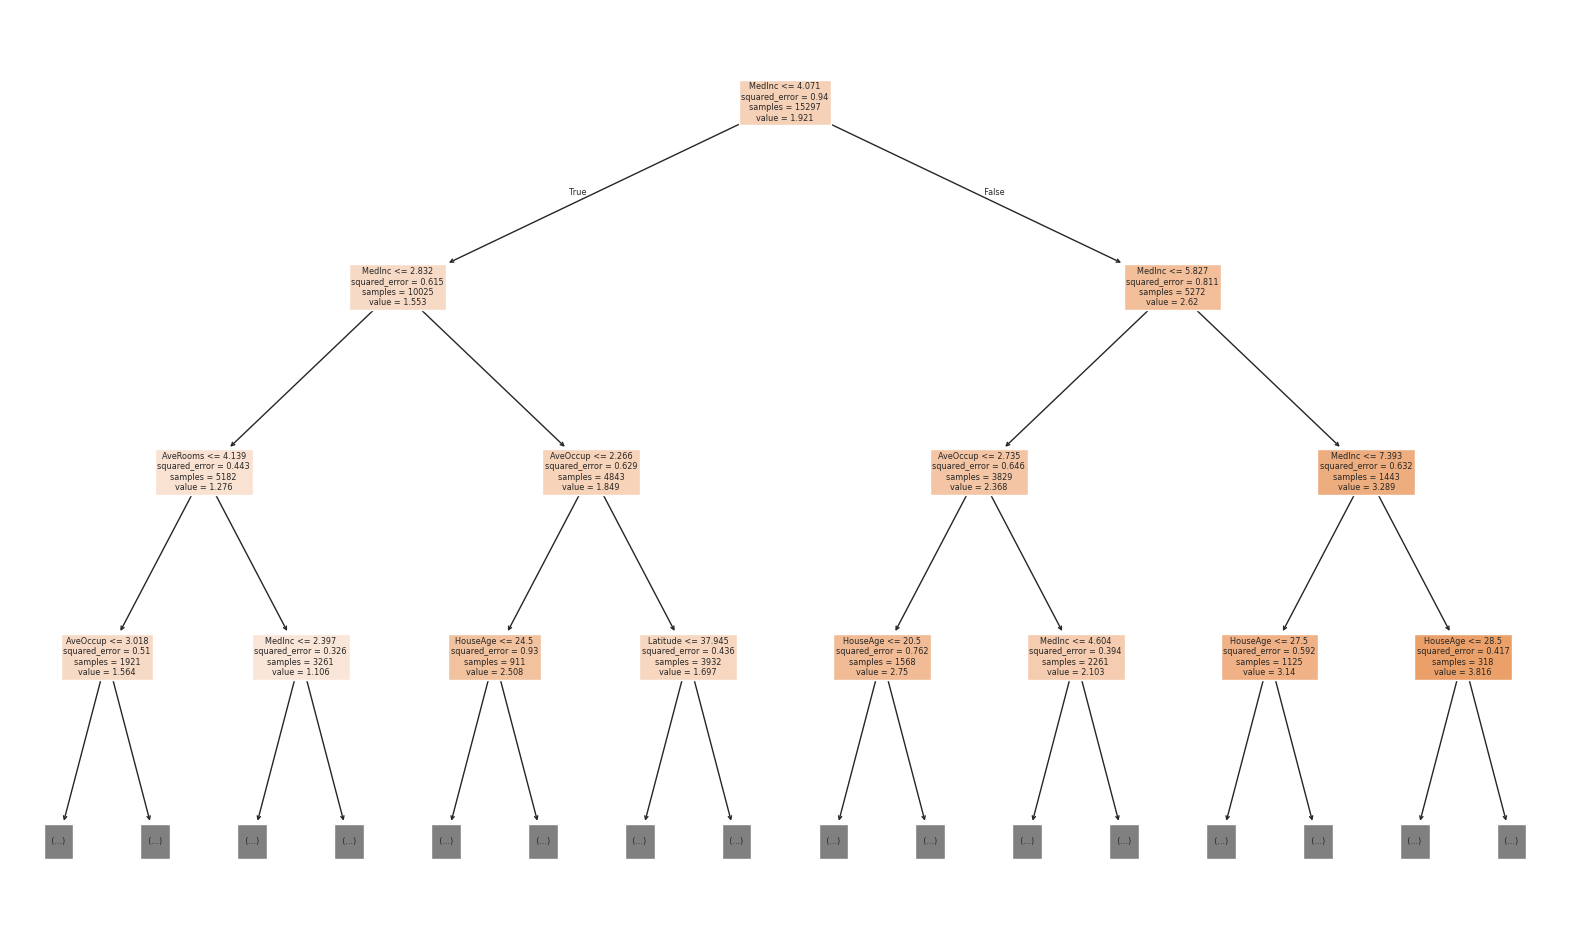

In [22]:
# Визуализация дерева
plt.figure(figsize=(20, 12))
plot_tree(decision_regressor, max_depth=3, feature_names=data.feature_names, class_names=data.target_names, filled=True)
plt.show()
    

# Подбор гиперпараметров для дерева c GridSearchCV

In [24]:
new_regressor = DecisionTreeRegressor()
params = {
    "max_depth": range(1, 10),
    "min_samples_leaf": range(20, 30),
    "min_samples_split": range(50, 80)
}

In [25]:
# Перебор всех возможных вариаций
gscv = GridSearchCV(new_regressor, param_grid=params, cv=5)
gscv.fit(X_test, y_test)
gscv.best_params_

{'max_depth': 9, 'min_samples_leaf': 29, 'min_samples_split': 50}

In [29]:
best_regressor = gscv.best_estimator_
best_regressor.fit(X_train, y_train)
best_regressor.score(X_test, y_test)

0.6717278591926353

In [39]:
feature_importances = pd.DataFrame(best_regressor.feature_importances_).T
feature_importances.columns = list(california_df)[:-1]
feature_importances.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.582743,0.03787,0.029827,0.002726,0.005578,0.137865,0.088945,0.114445


# Важность фич

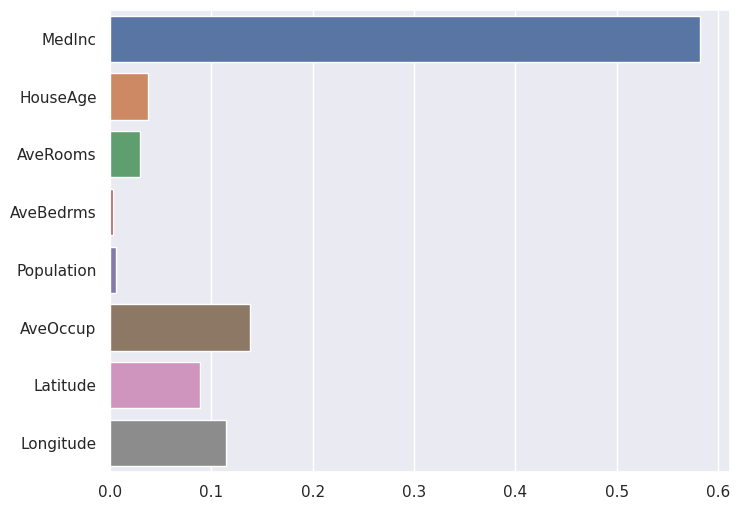

In [52]:
plt.figure(figsize=(8, 6))
sns.barplot(feature_importances, orient="h")
plt.show()

# Выводы
1. Первая модель дерева получила маленький скор, так как она сильно подстроилась под обучающую выборку и потеряла возможность обобщать входные данные. Для второго дерева были подобраны параметры перебором. Они 100% не самые оптимальные, зато модель обощает данные лучше. 
2. Сами по себе деревья не используются на практике, но важно понимать их работу, что бы работать с ансамблевыми методами. Так же они хороши тем, что легко интерпретируются, "white box"